# Logistic Regression, Before and After Feature Engineering

Import libraries. Read train and test dataset as df and df_test respectively.

In [1]:
!pip install imblearn
import pandas as pd
import seaborn as sns
import time
from datetime import date
import seaborn as sns
from matplotlib import pyplot as plt
import numpy as np
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from scipy.stats import zscore
from imblearn.datasets import make_imbalance
from imblearn.under_sampling import NearMiss
from imblearn.over_sampling import SMOTE
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [2]:
df = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')

Number of rows and columns in the training set.

In [3]:
print(df.shape)
print(df_test.shape)

(8068, 11)
(2627, 11)


In [4]:
print(df.isnull().sum())
print(df.shape)
print('\n')
print(df_test.isnull().sum())
print(df_test.shape)

ID                   0
Gender               0
Ever_Married       140
Age                  0
Graduated           78
Profession         124
Work_Experience    829
Spending_Score       0
Family_Size        335
Var_1               76
Segmentation         0
dtype: int64
(8068, 11)


ID                   0
Gender               0
Ever_Married        50
Age                  0
Graduated           24
Profession          38
Work_Experience    269
Spending_Score       0
Family_Size        113
Var_1               32
Segmentation         0
dtype: int64
(2627, 11)


## Before Feature Engineering

Drop all rows with at least one empty value. Notice that 1403 rows are dropped for traning set.

In [5]:
df_clean = df.dropna(axis = 0,how = 'any',inplace = False)

In [6]:
print(df_clean.isnull().sum())
print(df_clean.shape)


ID                 0
Gender             0
Ever_Married       0
Age                0
Graduated          0
Profession         0
Work_Experience    0
Spending_Score     0
Family_Size        0
Var_1              0
Segmentation       0
dtype: int64
(6665, 11)


Combine the two sets and use Label encoding to convert categorical features to numerics before splitting them. 

In [7]:
df_combined = pd.concat([df_clean,df_test],ignore_index = True)
label_encoder = preprocessing.LabelEncoder()
for column in ['Gender','Ever_Married','Graduated','Profession','Spending_Score','Var_1','Segmentation']:
    df_combined[column] = df_combined[column].astype('category').cat.codes
df_clean_encoded = df_combined.iloc[0:df_clean.shape[0],:]
df_test_encoded = df_combined.iloc[df_clean.shape[0]:df_clean.shape[0] + df_test.shape[0],:]
for column in (set(df_test_encoded.columns) - set(['Gender','Ever_Married','Graduated','Profession','Spending_Score','Var_1','Segmentation'])):
    df_test_encoded.loc[df_test_encoded[column].isnull(),column] = df_test_encoded[column].mean()

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


Train the Model, it takes around 1.4 seconds.

In [8]:
logReg = LogisticRegression(solver = 'lbfgs',multi_class='multinomial',max_iter = 1000, random_state=0)
start_time = time.time()
# Building a Logistic Regression Model
logReg.fit(df_clean_encoded.iloc[:,1:-1], df_clean_encoded.iloc[:,-1])

#print duration of model
today = date.today()
print("--- %s seconds ---" % (time.time() - start_time))

--- 1.4346907138824463 seconds ---


Predict and test the model on the test set, accuracy rate is about 32%.

In [9]:
y_hat = logReg.predict(df_test_encoded.iloc[:,1:-1])
print(accuracy_score(y_hat,df_test_encoded.iloc[:,-1]))

0.3269889607917777


## Feature Engineering -- Keep entries with null value

This time we won't drop rows with empty cells anymore to avoid losing thousands of entries. We fill in the mean value to each empty cells for numerical features, and -1 to categorical features.

In [10]:
df_combined2 = pd.concat([df,df_test],ignore_index = True)
label_encoder2 = preprocessing.LabelEncoder()
for column in ['Gender','Ever_Married','Graduated','Profession','Spending_Score','Var_1','Segmentation']:
    df_combined2[column] = df_combined2[column].astype('category').cat.codes
df_encoded = df_combined2.iloc[0:df.shape[0],:]
df_test_encoded2 = df_combined2.iloc[df.shape[0]:df.shape[0] + df_test.shape[0],:]
for column in (set(df_encoded.columns) - set(['Gender','Ever_Married','Graduated','Profession','Spending_Score','Var_1','Segmentation'])):
    df_encoded.loc[df_encoded[column].isnull(),column] = df_encoded[column].mean()
    df_test_encoded2.loc[df_test_encoded2[column].isnull(),column] = df_test_encoded2[column].mean()


C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


Train and Test. This time accuracy rate is around 33.2%, a 0.5% increase from last time. 

In [11]:
logReg2 = LogisticRegression(solver = 'lbfgs',multi_class='multinomial',max_iter = 1000, random_state=0)
start_time = time.time()

logReg2.fit(df_encoded.iloc[:,1:-1], df_encoded.iloc[:,-1])

today = date.today()
print("--- %s seconds ---" % (time.time() - start_time))

--- 1.5513882637023926 seconds ---


In [54]:
y_hat2 = logReg2.predict(df_test_encoded.iloc[:,1:-1])
print(accuracy_score(y_hat2,df_test_encoded2.iloc[:,-1]))

0.3319375713741911


## Feature Engineering -- Feature Selection

Perform Correlation Analysis. Notice that none of the features and considered strongly correlated (abs > 0.5) to our target 'Segmentation'. However, in the second image, notice that all features, with a possible exception of Gender and Var_1, have an impact on classification of Segmentation.

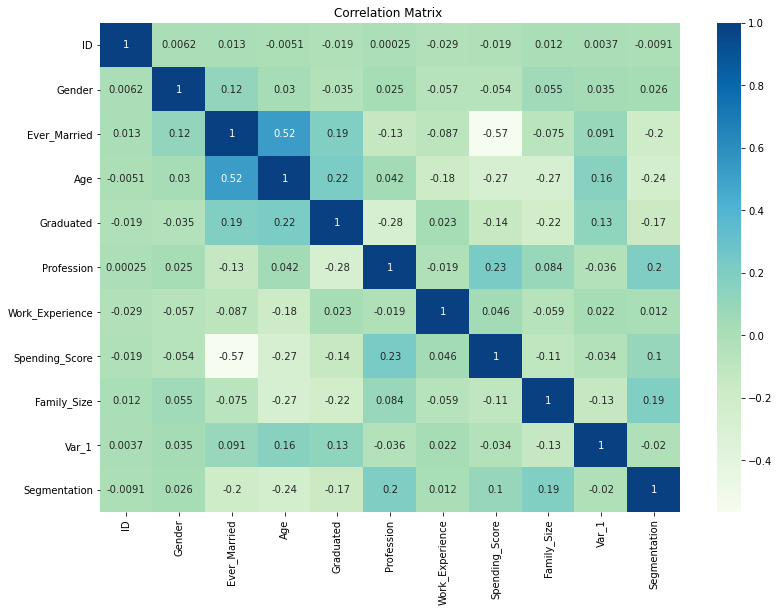

In [13]:
corr_mat = df_encoded.corr()
plt.figure(figsize=(13,9))
ax = sns.heatmap(data=corr_mat, annot=True,
            cmap='GnBu')
plt.title('Correlation Matrix ')
plt.show()

<function matplotlib.pyplot.show(*args, **kw)>

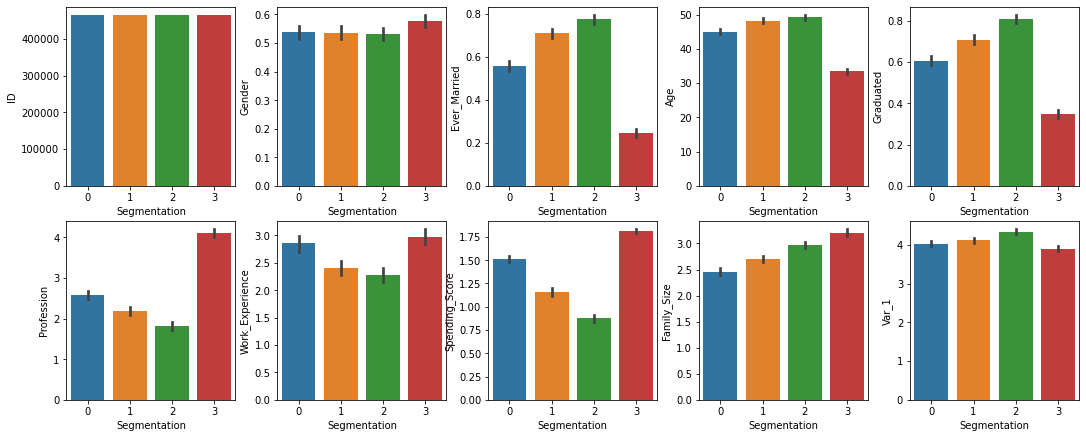

In [14]:
fig, ax = plt.subplots(ncols=5, nrows=2, figsize=(15, 6))
ax = ax.flatten()
index=0
for i in df_encoded.columns:
  if i != 'Segmentation':
    sns.barplot(x='Segmentation', y=i, data=df_encoded, ax=ax[index])
    index+=1
plt.tight_layout(pad=0.4)
plt.show

We can try to only include features whose correlation coefficient is greater than 0.1. After traning and testing, accrucary rate is found to reduce by 0.04%. Therefore it might be a better idea not to exclude these features.

In [15]:
df_encoded_selected = df_encoded.loc[:,abs(corr_mat['Segmentation']) > 0.1]
df_test_encoded_selected = df_test_encoded.loc[:,abs(corr_mat['Segmentation']) > 0.1]

In [56]:
logReg3 = LogisticRegression(solver = 'lbfgs',multi_class='multinomial',max_iter = 1000, random_state=0)
start_time = time.time()

logReg3.fit(df_encoded_selected.iloc[:,0:-1], df_encoded_selected.iloc[:,-1])

today = date.today()
print("--- %s seconds ---" % (time.time() - start_time))

--- 1.1290123462677002 seconds ---


In [57]:
y_hat3 = logReg3.predict(df_test_encoded_selected.iloc[:,0:-1])
print(accuracy_score(y_hat3,df_test_encoded_selected.iloc[:,-1]))

0.33155690902169777


## Feature Engineering -- Imbalanced Learning

Perform Imbalanced Learning. Notice that the number of segmentation of value 3 is larger than the other 3 values. However, the result of 32.6% of accuracy rate, implies that we should not use imbalanced learning here.

In [61]:
print(df_encoded['Segmentation'].value_counts())

3    2268
0    1972
2    1970
1    1858
Name: Segmentation, dtype: int64


In [62]:
smote = SMOTE(random_state = 0)
X_smote, y_smote = smote.fit_resample(df_encoded.iloc[:,1:-1], df_encoded.iloc[:,-1])
print(y_smote.value_counts())

3    2268
2    2268
1    2268
0    2268
Name: Segmentation, dtype: int64


In [63]:
logReg4 = LogisticRegression(solver = 'lbfgs',multi_class='multinomial',max_iter = 1000, random_state=0)
start_time = time.time()

logReg4.fit(X_smote, y_smote)

today = date.today()
print("--- %s seconds ---" % (time.time() - start_time))

--- 1.5220515727996826 seconds ---


In [64]:
y_hat4 = logReg4.predict(df_test_encoded2.iloc[:,1:-1])
print(accuracy_score(y_hat4,df_test_encoded2.iloc[:,-1]))

0.32584697373429766


## Feature Engineering -- Principle Component Analysis

In [93]:
scaler = StandardScaler()
x_scaled = scaler.fit_transform(df_encoded.iloc[:,1:-1])
x_test_scaled = scaler.fit_transform(df_test_encoded2.iloc[:,1:-1])

In [94]:
pca = PCA(n_components = 5)
x = pca.fit_transform(x_scaled)
x_test = pca.fit_transform(x_test_scaled)

In [95]:
logReg5 = LogisticRegression(solver = 'lbfgs',multi_class='multinomial',max_iter = 1000, random_state=0)
start_time = time.time()

logReg5.fit(x, df_encoded.iloc[:,-1])

today = date.today()
print("--- %s seconds ---" % (time.time() - start_time))

--- 0.03586864471435547 seconds ---


In [96]:
y_hat5 = logReg5.predict(x_test)
print(accuracy_score(y_hat5,df_test_encoded2.iloc[:,-1]))

0.3136657784545108
